In [1]:
from pathlib import Path
if Path.cwd().parent.stem == 't1':
    %cd ..

/home/step/Personal/UCH/2021-sem1/VisionComp/t1


In [2]:
import train
from train import *
from dataset import ClothingSmall, parse_function, train_preprocess
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
print(train.__doc__)


jsaavedr, 2020
This allows you to train and test your model

Before using this program, set the path where the folder "covnet2"  is stored.
To use train.py, you will require to send the following parameters :
 * -config : A configuration file where a set of parameters for data construction and trainig is set.
 * -name: A section name in the configuration file.
 * -mode: [train, test] for training, testing, or showing  variables of the current model. By default this is set to 'train'
 * -save: Set true for saving the model


 Extension made by Victor Faraggi, 2021

 Added modularity. Now you can import the following functions:
    - create_config(name, config_file=None, config_str=None)
        -> return a ConfigurationFile from config_file path or config_str
    - parse_config(config)
        -> returns dict w/ tfr_files
    - load_dataset(config, tfr_train_file, tfr_test_file)
        -> returns a dict w/ train/test datasets, mean_image, input_shape and number_of_classes
    - create

# ResNet-50


In [4]:
resnet50_config = \
"""[FASHION-RESNET50]
# Training Related
NUM_EPOCHS = 25
NUM_CLASSES = 19
BATCH_SIZE = 128
SNAPSHOT_STEPS = 500
VALIDATION_STEPS = 100
LEARNING_RATE = 0.003
USE_L2 = True
WEIGHT_DECAY = 1e-4

SNAPSHOT_DIR = snapshots/snapshots-r50/

# Dataset Related
DATA_DIR = data/clothing-small/
SHUFFLE_SIZE = 10000
CHANNELS = 3
IMAGE_TYPE = IMAGE
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

#for tf_records to use multithreads
USE_MULTITHREADS = True
NUM_THREADS = 10

#CKPFILE is used for fine tunning
#CKPFILE =/home/step/Personal/UCH/2021-sem1/VisionComp/t1/chks
"""

with open("configs/t1_resnet50.config", 'w') as conf:
    conf.write(resnet50_config)

## Configuration and Dataset

In [5]:
config = create_config("FASHION-RESNET50", "configs/t1_resnet50.config")
tfr_files = parse_config(config, mode='train')
datasets = load_dataset(config, tfr_files['train'], tfr_files['test'], 'train')

In [6]:
from dataset import ClothingSmall

process_func = lambda img, label : train_preprocess(img, label, seed=[8, 8])

csDataset = ClothingSmall(data_dir = config.get_data_dir())

csDataset.prepare()

csDataset.make_ds(parse_function, process_func)


# datasets = {
#     'train' : csDataset.train_ds,
#     'test' : csDataset.test_ds
# }


## Optimizer

In [7]:
cosine_sched = create_scheduler(config)
opt = create_opt('adam', config)

## Create Callbacks

## Model

In [8]:
model = create_model(config, 'resnet-50', csDataset.input_shape, use_mixed=True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6
Model is Resnet-50
(224, 224, 3)
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
backbone (ResNetBackbone)    multiple                  23549568  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  38931     
Total params: 23,588,499
Trainable params: 23,543,059
Non-trainable params: 45,440
_________________________________________________________________


In [9]:
tb_cb, chk_cb = create_cbs(config)

## Run

In [10]:
datasets['train'] = datasets['train'].prefetch(1)
datasets['test'] = datasets['test'].prefetch(1)

In [11]:
history = run_model('train', model, opt, datasets, config, [chk_cb], [tb_cb])

Epoch 1/25
250/250 [==============================] - 39s 106ms/step - loss: 2.8659 - accuracy: 0.1549 - val_loss: 12.1791 - val_accuracy: 0.1153
Epoch 2/25
250/250 [==============================] - 29s 98ms/step - loss: 2.1399 - accuracy: 0.3059 - val_loss: 30.9865 - val_accuracy: 0.1116
Epoch 3/25
250/250 [==============================] - 30s 101ms/step - loss: 1.9646 - accuracy: 0.3586 - val_loss: 2.3985 - val_accuracy: 0.3274
Epoch 4/25
250/250 [==============================] - 29s 100ms/step - loss: 1.7169 - accuracy: 0.4325 - val_loss: 2.1411 - val_accuracy: 0.3400
Epoch 5/25
250/250 [==============================] - 30s 103ms/step - loss: 1.5971 - accuracy: 0.4743 - val_loss: 1.8304 - val_accuracy: 0.4232
Epoch 6/25
250/250 [==============================] - 29s 101ms/step - loss: 1.5162 - accuracy: 0.4995 - val_loss: 1.6605 - val_accuracy: 0.4689
Epoch 7/25
250/250 [==============================] - 29s 100ms/step - loss: 1.4434 - accuracy: 0.5222 - val_loss: 1.5901 - val_a

In [12]:
history.history

{'loss': [2.573782444000244,
  2.046067953109741,
  1.8629728555679321,
  1.6846554279327393,
  1.5758413076400757,
  1.495287537574768,
  1.4220274686813354,
  1.3596992492675781,
  1.2989290952682495,
  1.2496745586395264,
  1.2474238872528076,
  1.1791621446609497,
  1.1158854961395264,
  1.0716135501861572,
  1.0227272510528564,
  0.9817516207695007,
  0.9268696904182434,
  0.8778157234191895,
  0.8346605896949768,
  0.7846695184707642,
  0.738061249256134,
  0.6789119243621826,
  0.6240339875221252,
  0.5849893093109131,
  0.5409647822380066],
 'accuracy': [0.1946086287498474,
  0.3336773216724396,
  0.3866216242313385,
  0.4450698792934418,
  0.480564147233963,
  0.5051755905151367,
  0.5284110307693481,
  0.5494261384010315,
  0.5682209134101868,
  0.578916072845459,
  0.5821371674537659,
  0.6083122491836548,
  0.6273884177207947,
  0.6401788592338562,
  0.6560652852058411,
  0.6710135340690613,
  0.6875566840171814,
  0.7053194642066956,
  0.7196735143661499,
  0.7379053831100

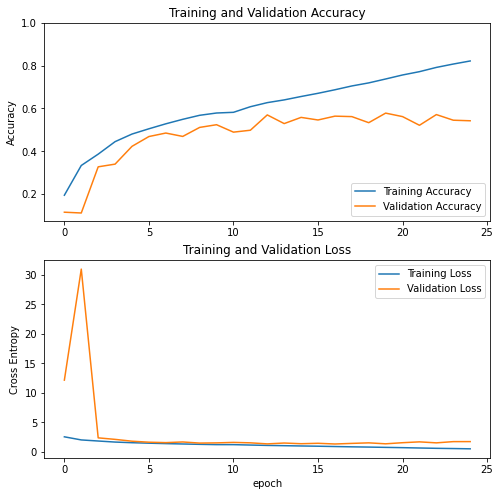

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()